# part0: imports

In [24]:
import os, sys, pathlib
from pprint import pprint
import gc
import pickle
from importlib import reload
import logging, warnings
logging.basicConfig(level=logging.ERROR)
from IPython.display import display, clear_output

import pandas as pd
import numpy as np
import sklearn
from sklearn.decomposition import PCA
import scipy.linalg as linalg
from scipy.stats import pearsonr

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib
from matplotlib.ticker import MaxNLocator
from matplotlib.collections import LineCollection
from matplotlib.backends.backend_pdf import PdfPages
%matplotlib inline
%config InlineBackend.figure_formats = ['png2x']

import pyaldata as pyal
import defs

try:
    nbPath = pathlib.Path.cwd()
    RepoPath = nbPath.parent
    os.chdir(RepoPath)

    from tools import utilityTools as utility
    from tools import dataTools as dt
    import params
    
    set_rc =  params.set_rc_params
    set_rc()
    root = params.root
    reload(dt)
    reload(defs)
    reload(params)
finally:
    os.chdir(nbPath)

# reading data

In [10]:
animalList = ['mouse-data']

animalFiles = []
for animal in animalList:
    animalFiles.extend(utility.find_file(root/animal, 'mat'))


AllDFs=[]
for fname in animalFiles:
    print(fname)
    df = dt.load_pyal_data(fname)
    df['mouse'] = fname.split(os.sep)[-1][fname.split(os.sep)[-1].find('WR'):].split('_')[0]
    df['file'] = fname.split(os.sep)[-1]
    df = defs.prep_general_mouse(df)
    AllDFs.append(df)

clear_output()

# Check the duration of reach and pull

In [15]:
def reach_phase_len(df):
    keys = np.unique(df.target_id)
    out = {key:[] for key in keys}
    for i, traj in enumerate(df.hTrjB):
        a = traj[df.idx_movement_on[i]:df.idx_pull_on[i],0]
        cleanTraj = a[np.logical_not(np.isnan(a))]
        out[df.target_id[i]].append(len(cleanTraj) * df.bin_size[i])

    return out

def pull_phase_len(df):
    keys = np.unique(df.target_id)
    out = {key:[] for key in keys}
    for i, traj in enumerate(df.hTrjB):
        a = traj[df.idx_pull_on[i]:,0]
        cleanTraj = a[np.logical_not(np.isnan(a))]
        out[df.target_id[i]].append(len(cleanTraj) * df.bin_size[i])

    return out

def trial_len(df):
    keys = np.unique(df.target_id)
    out = {key:[] for key in keys}
    for i, traj in enumerate(df.hTrjB):
        a = traj[df.idx_movement_on[i]:df.idx_pull_off[i],0]
        cleanTraj = a[np.logical_not(np.isnan(a))]
        out[df.target_id[i]].append(len(cleanTraj) * df.bin_size[i])

    return out

plot the duration of pull and reach

Text(0.09, 0.5, 'Different datasets')

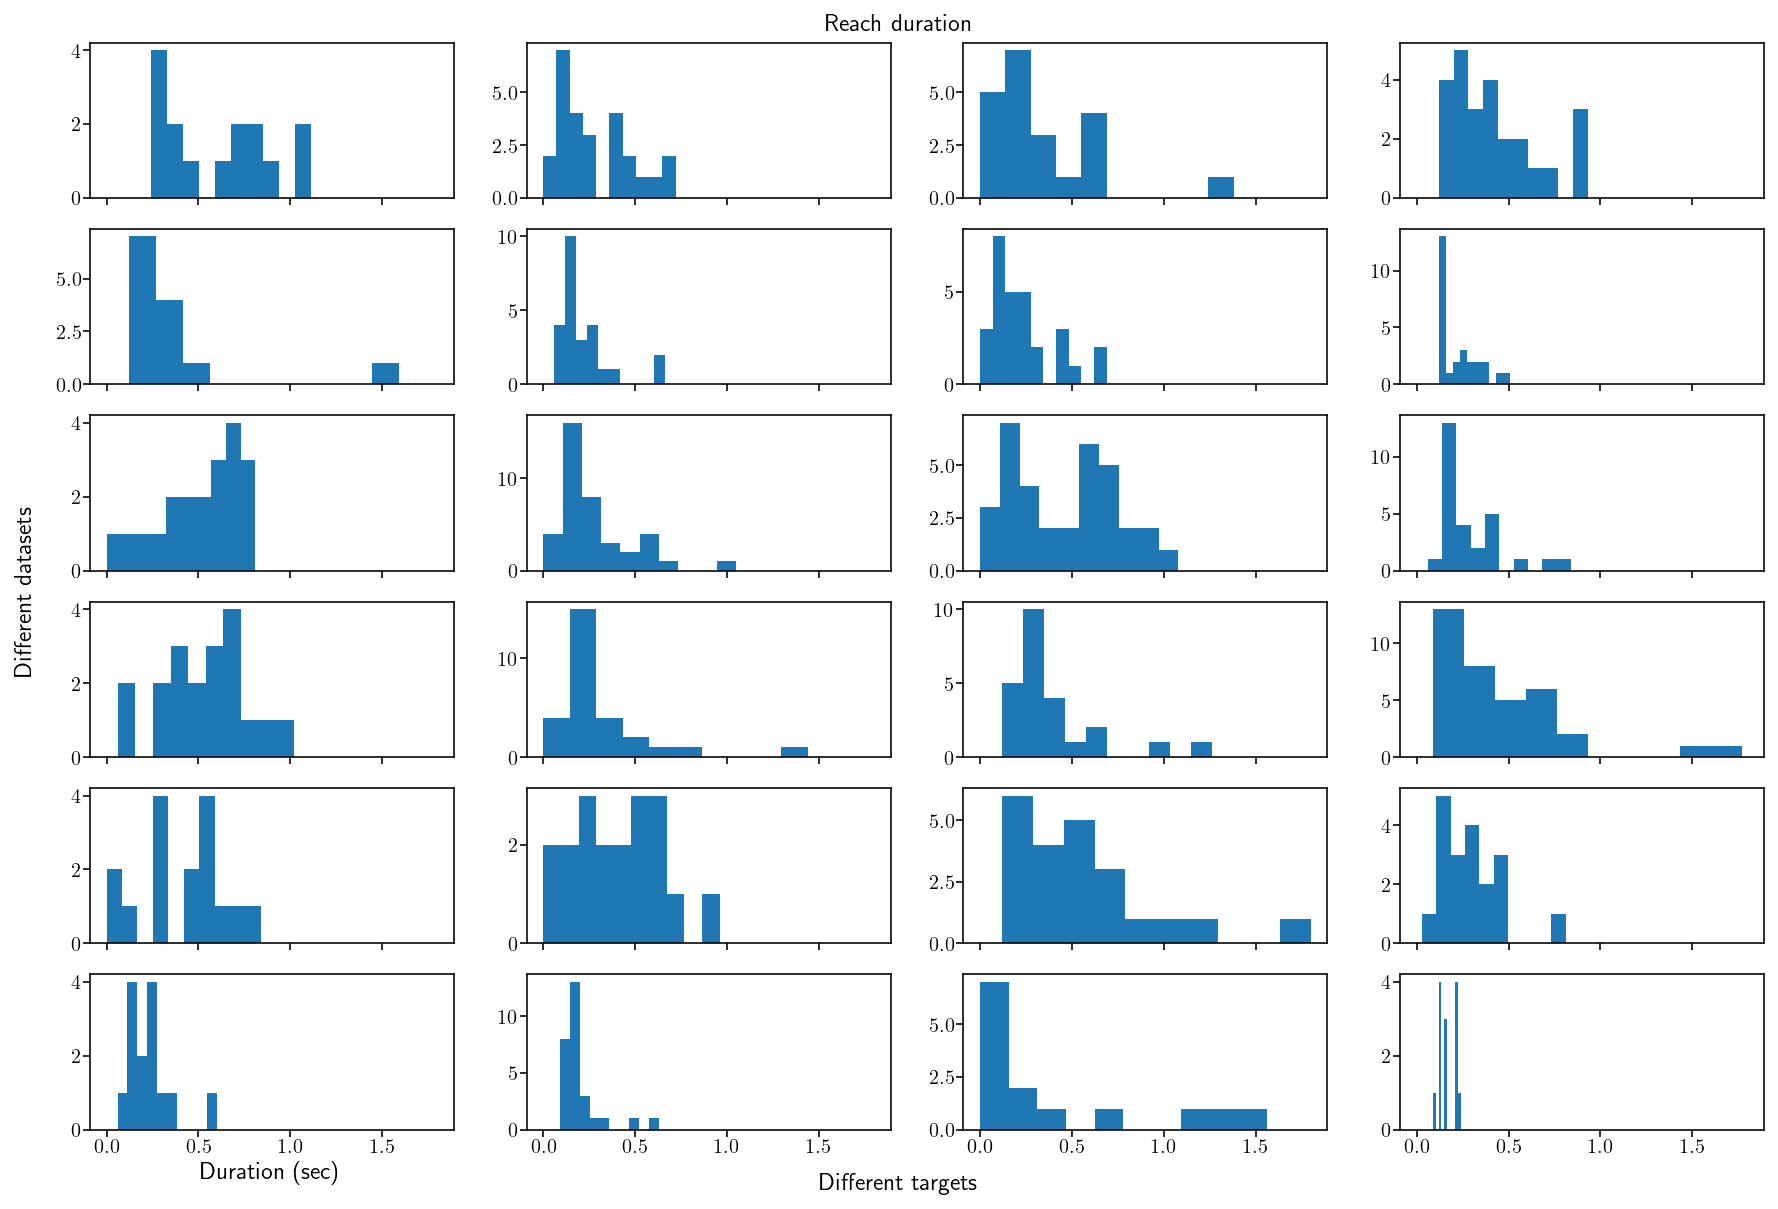

In [4]:
fig,axes = plt.subplots(len(AllDFs),len(np.unique(df.target_id)),figsize=(15,10), sharex=True)


for row,df in enumerate(AllDFs):
    a = reach_phase_len(df)
    for col, data in a.items():
        axes[row,col].hist(np.array(data))
fig.suptitle('Reach duration', y=0.9);
axes[-1,0].set_xlabel('Duration (sec)')
fig.supxlabel('Different targets', y=.08)
fig.supylabel('Different datasets', x=.09)

Text(0.09, 0.5, 'Different datasets')

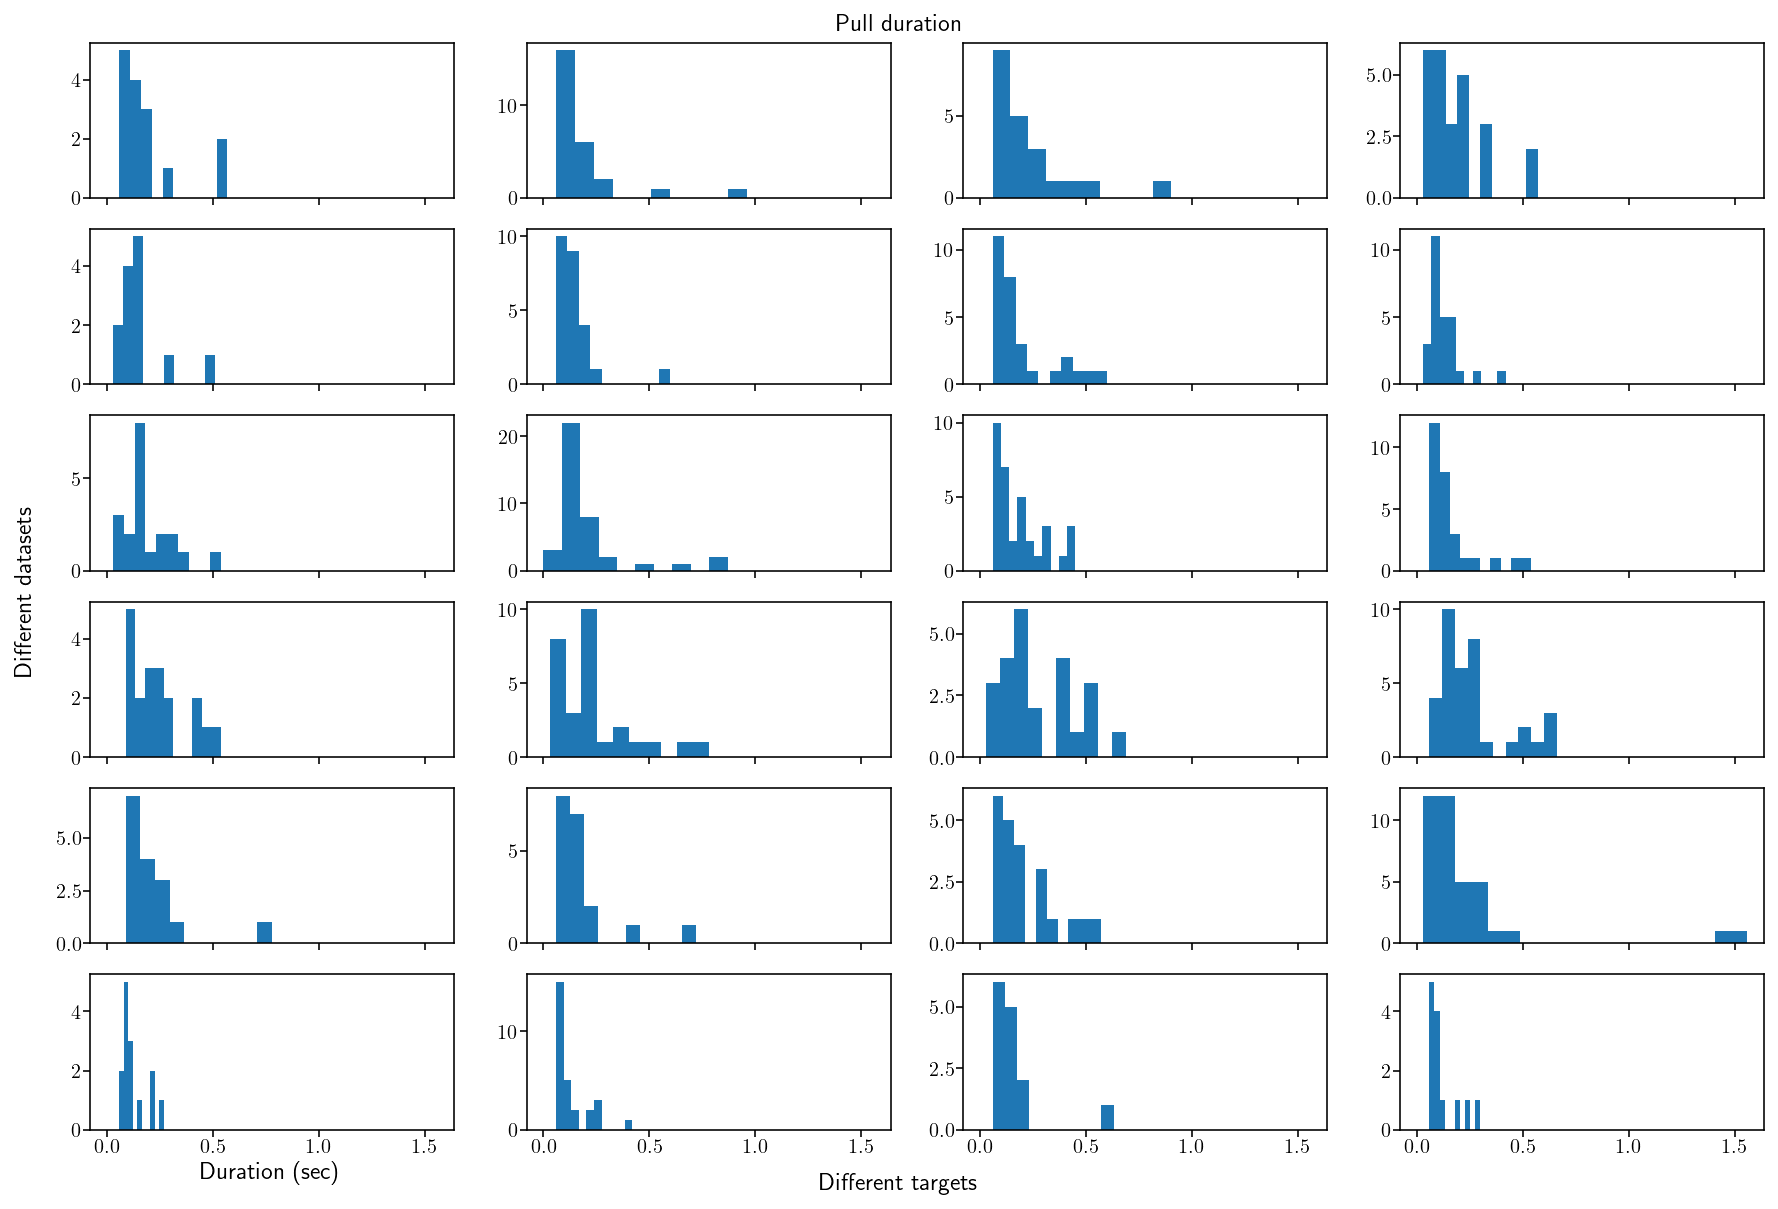

In [5]:
fig,axes = plt.subplots(len(AllDFs),len(np.unique(df.target_id)),figsize=(15,10), sharex=True)


for row,df in enumerate(AllDFs):
    a = pull_phase_len(df)
    for col, data in a.items():
        axes[row,col].hist(np.array(data))
fig.suptitle('Pull duration', y=0.9);
axes[-1,0].set_xlabel('Duration (sec)')
fig.supxlabel('Different targets', y=.08)
fig.supylabel('Different datasets', x=.09)

Text(0.09, 0.5, 'Different datasets')

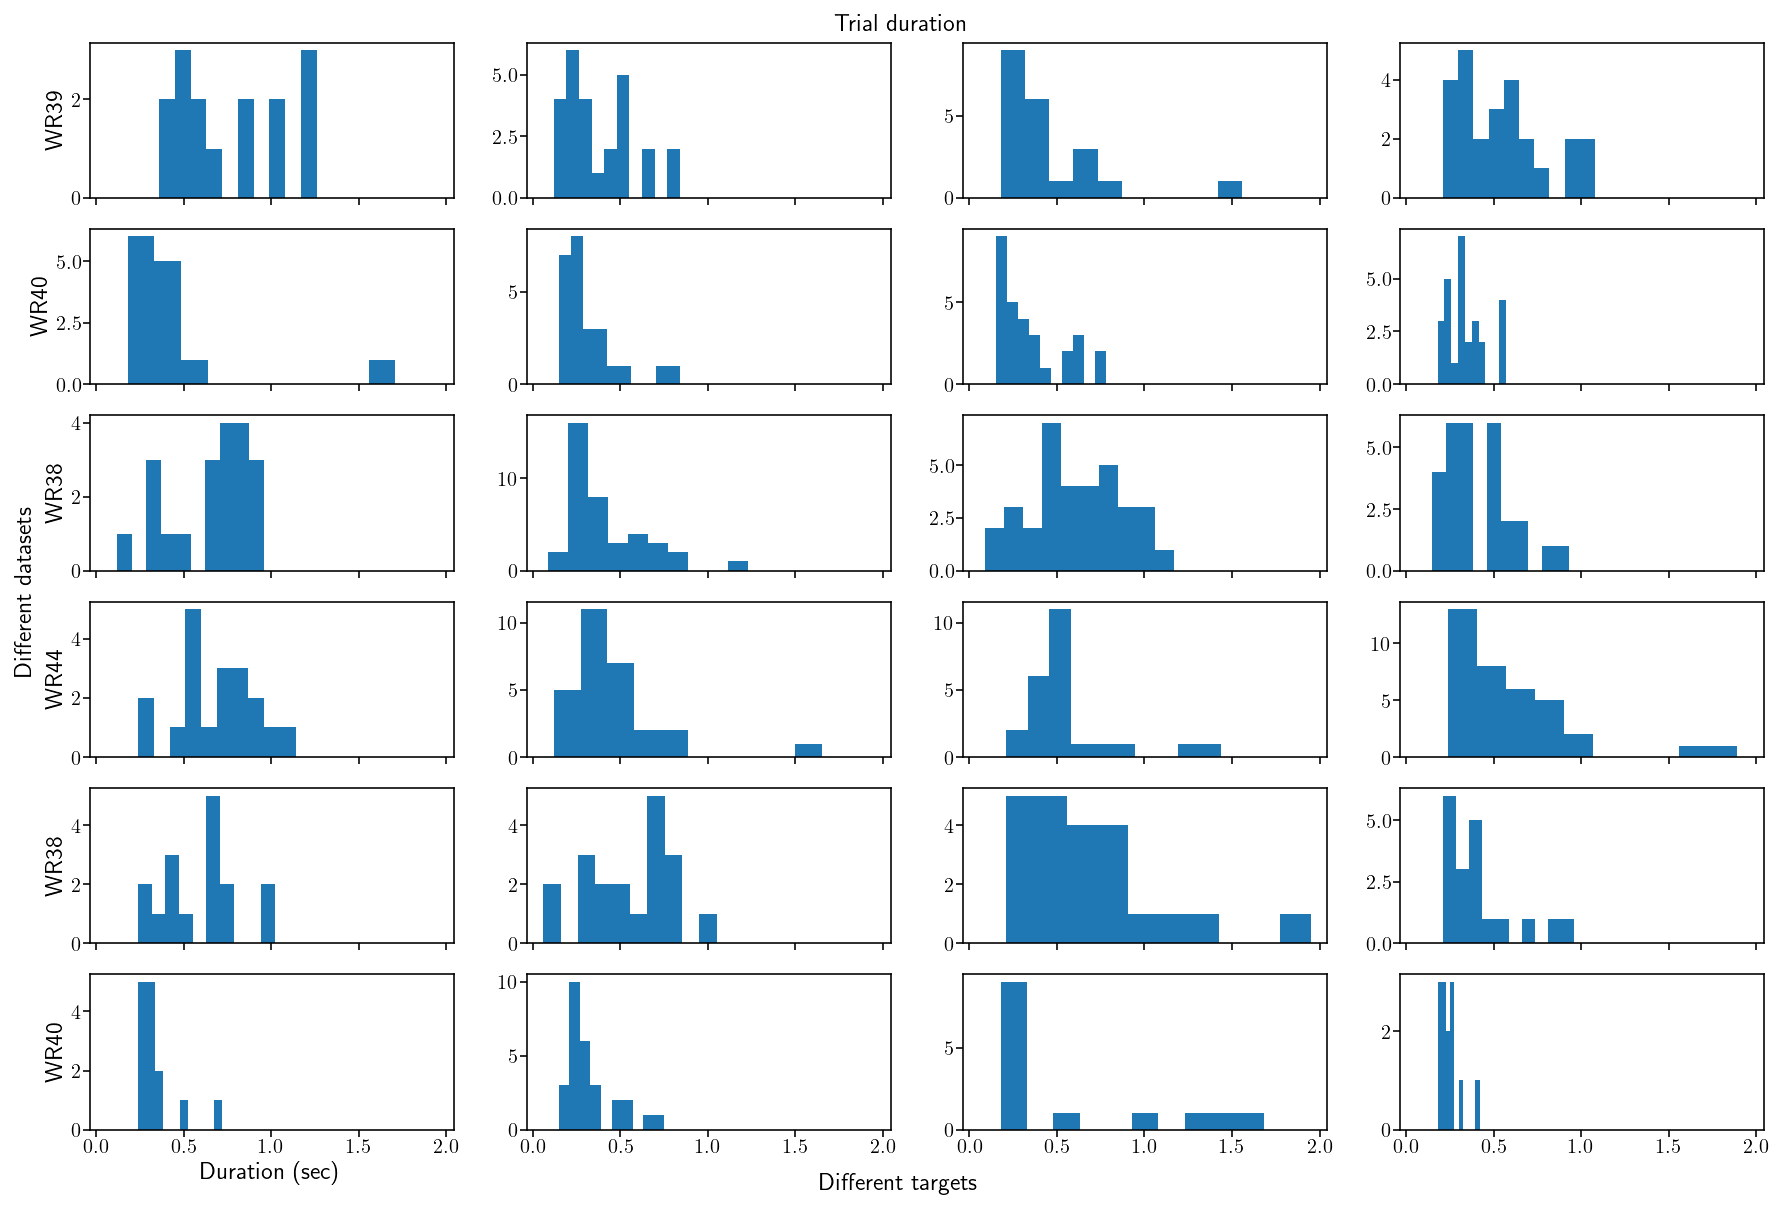

In [16]:
fig,axes = plt.subplots(len(AllDFs),len(np.unique(df.target_id)),figsize=(15,10), sharex=True)


for row,df in enumerate(AllDFs):
    a = trial_len(df)
    for col, data in a.items():
        axes[row,col].hist(np.array(data))
    axes[row,0].set_ylabel(df.mouse[0])
fig.suptitle('Trial duration', y=0.9);
axes[-1,0].set_xlabel('Duration (sec)')
fig.supxlabel('Different targets', y=.08)
fig.supylabel('Different datasets', x=.09)

Correlate behaviour during the trial

In [37]:
within_corrs = {}
for df in AllDFs:
    within_corrs[df.file[0]] = np.zeros((df.shape[0],df.shape[0]))
    for i, vel1 in enumerate(df.hVelB):
        a = vel1[df.idx_movement_on[i]:df.idx_pull_off[i],:]
        for j, vel2 in enumerate(df.hVelB):
            if j<i: continue
            b = vel2[df.idx_movement_on[j]:df.idx_pull_off[j],:]
            a_,b_ = dt.warp_time(a,b)
            r = [pearsonr(aa,bb)[0] for aa,bb in zip(a_.T,b_.T)]
            within_corrs[df.file[0]][i,j] = np.mean(r)


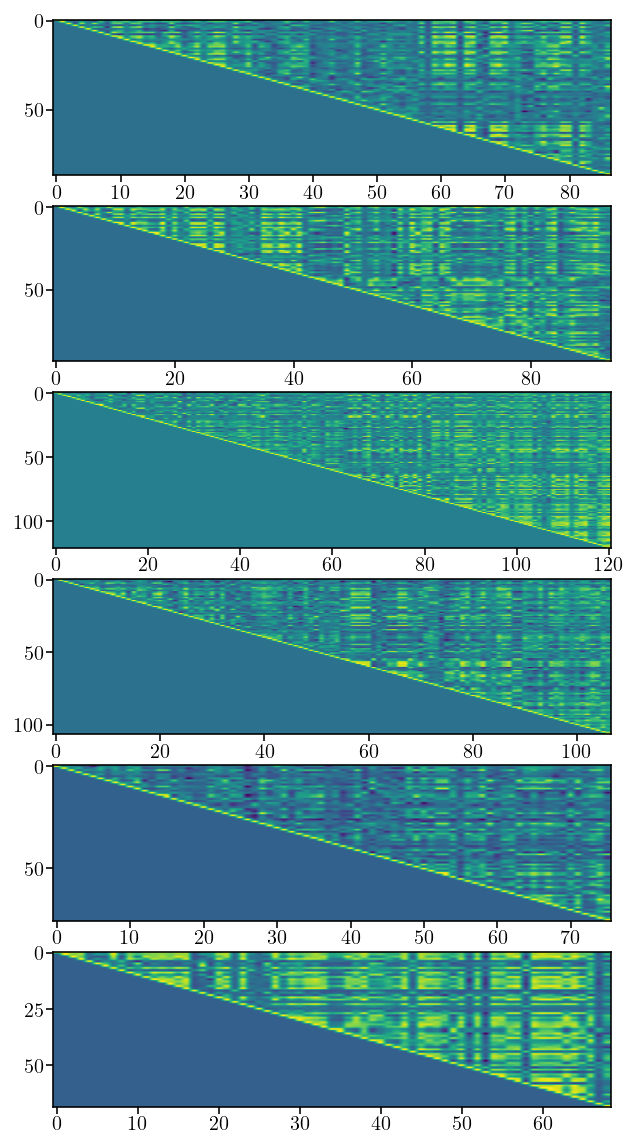

In [48]:
fig,axes = plt.subplots(len(AllDFs),1,figsize=(5,10))

for i, corrs in enumerate(within_corrs.values()):
    axes[i].imshow(corrs,aspect='auto')

just plot the pull phase

In [5]:
def plot_reach_phase(axes,df):
    for i,traj in enumerate(df.hTrjB):
        if df.target_id[i] in (0,):
            color = 'r'
        elif df.target_id[i] in (2,):
            color = 'b'
        else:
            continue
        axes[0].plot(traj[df.idx_movement_on[i]:df.idx_pull_on[i],0],traj[df.idx_movement_on[i]:df.idx_pull_on[i],1],lw=.5, color=color)
    axes[0].set_title('HEAVY targets --- Reach')

    for i,traj in enumerate(df.hTrjB):
        if df.target_id[i] in (1,):
            color = 'r'
        elif df.target_id[i] in (3,):
            color = 'b'
        else:
            continue
        axes[1].plot(traj[df.idx_movement_on[i]:df.idx_pull_on[i],0],traj[df.idx_movement_on[i]:df.idx_pull_on[i],1],lw=.5, color=color)
    axes[1].set_title('LIGHT targets --- Reach')

In [6]:
def plot_pull_phase(axes,df):
    for i,traj in enumerate(df.hTrjB):
        if df.target_id[i] in (0,):
            color = 'r'
        elif df.target_id[i] in (2,):
            color = 'b'
        else:
            continue
        axes[0].plot(traj[df.idx_pull_on[i]:,0],traj[df.idx_pull_on[i]:,1],lw=.5, color=color)
    axes[0].set_title('HEAVY targets --- Pull')

    for i,traj in enumerate(df.hTrjB):
        if traj.ndim<2:
            continue
        if df.target_id[i] in (1,):
            color = 'r'
        elif df.target_id[i] in (3,):
            color = 'b'
        else:
            continue
        axes[1].plot(traj[df.idx_pull_on[i]:,0],traj[df.idx_pull_on[i]:,1],lw=.5, color=color)
    axes[1].set_title('LIGHT targets --- Pull')

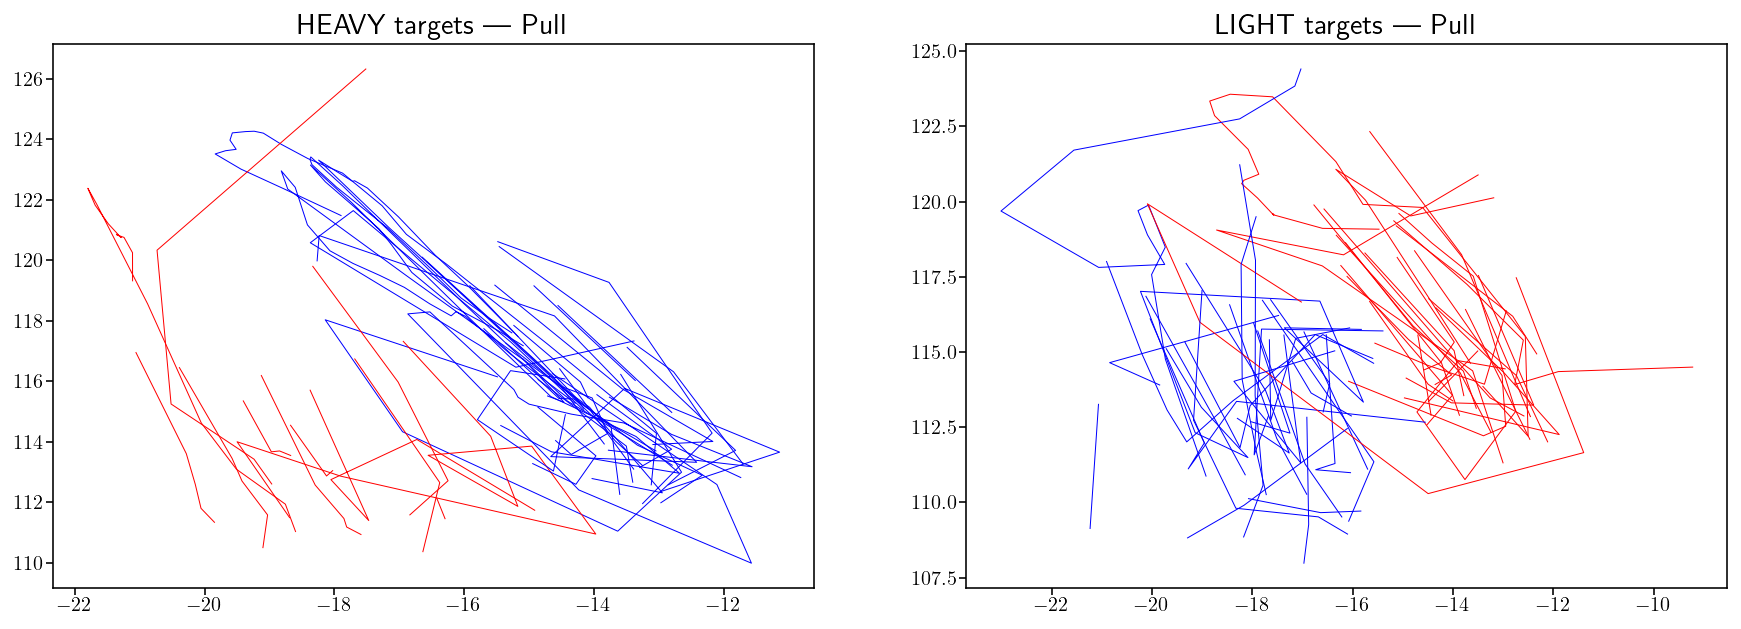

In [7]:
# %config InlineBackend.close_figures = True
fig,axes = plt.subplots(1,2,figsize=(15,5))

plot_pull_phase(axes,df)

# plot all the data

In [64]:
with PdfPages(pathlib.Path.cwd() / 'figures' / 'mouse-traj.pdf') as pdf:
    for df in AllDFs:
        fig,axes = plt.subplots(2,2,figsize=(15,10))
        
        plot_pull_phase(axes[1,:],df)
        plot_reach_phase(axes[0,:],df)
        fig.suptitle(f"Session: {df.file[0].replace('_','-')}")
        
        pdf.savefig()  # saves the current figure into a pdf page
        plt.close()

the pull phase is more consistent:

**check the duration of the pull phase**

In [65]:
def pull_phase_duration(df):
    light = []
    heavy = []
    for i,traj in enumerate(df.hTrjB):
        if df.target_id[i] in (0,2):
            key = heavy
        elif df.target_id[i] in (1,3):
            key = light
        else:
            continue
        getattr(key,'append')((np.sum(np.logical_not(np.isnan(traj[:,0])))-df.idx_pull_on[i])*df.bin_size[0])

    return light, heavy

    
with PdfPages(pathlib.Path.cwd() / 'figures' / 'mouse-pull-duration.pdf') as pdf:
    for df in AllDFs:
        fig,axes = plt.subplots(1,2,figsize=(10,5))
        
        light, heavy = pull_phase_duration(df)
        axes[0].hist(light)
        axes[0].set_title('light')
        axes[1].hist(heavy)
        axes[1].set_title('heavy')
        
        for ax in axes:
            ax.set_xlim([0,ax.get_xlim()[1]])
            ax.set_xlabel('Pull duration (s)')
            ax.set_ylabel(r'\# of trials')
        
        fig.suptitle(f"Session: {df.file[0].replace('_','-')}")
        
        pdf.savefig()  # saves the current figure into a pdf page
        plt.close()
print('Done')

Done


# Plot average firing rates

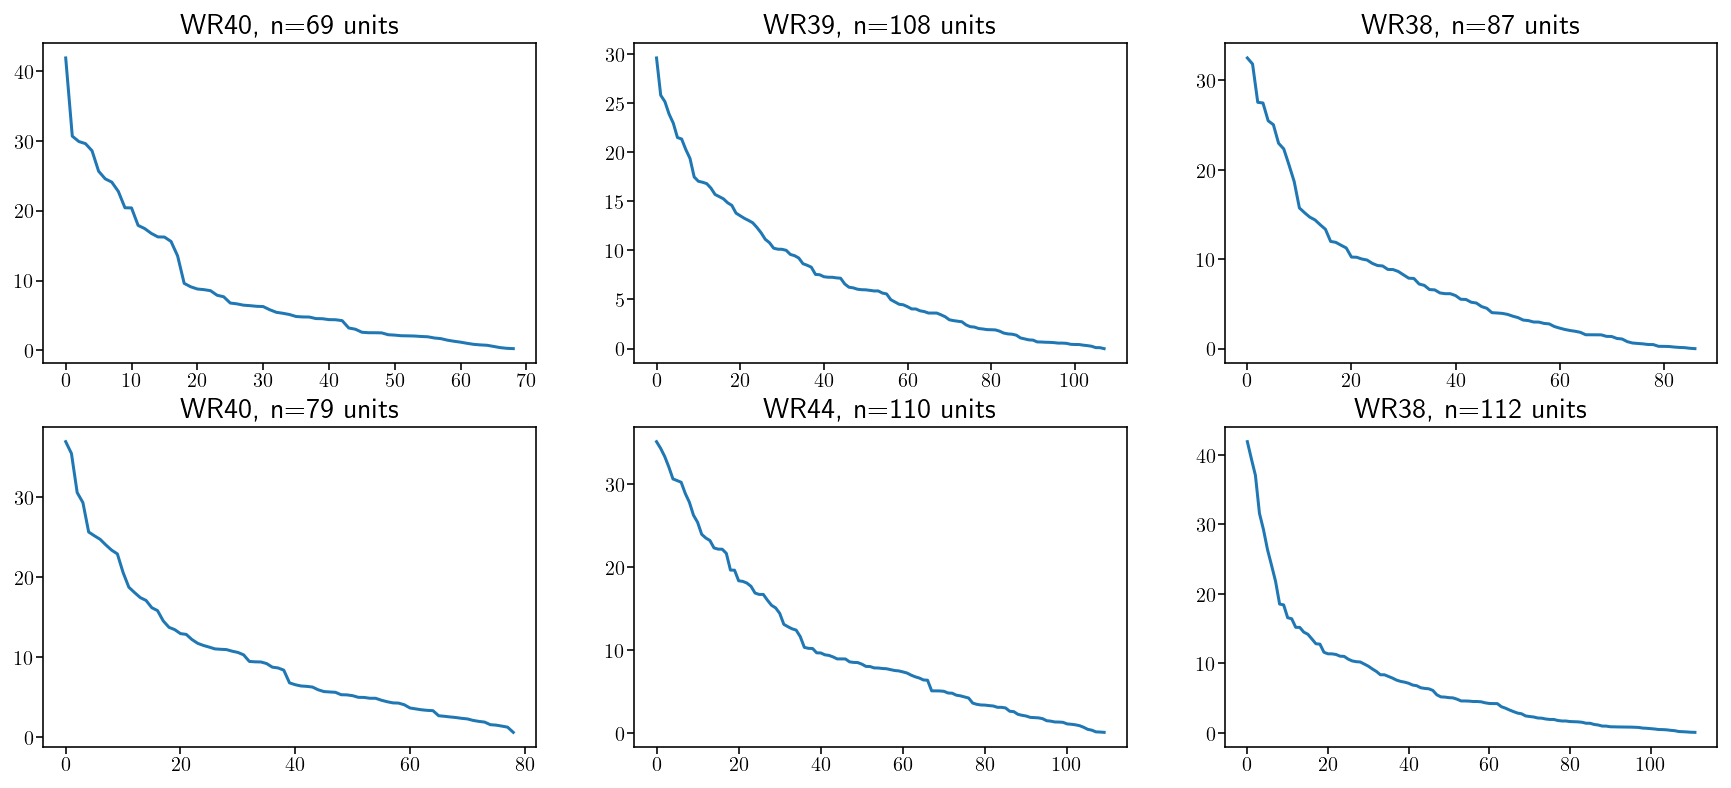

In [9]:
warnings.filterwarnings("ignore")
plt.figure(figsize=(15,10))

signal = 'M1_rates'
signal = 'Str_rates'
for i,df in enumerate(AllDFs):
    ax = plt.subplot(3,3,i+1)    
    if signal not in df.columns: continue
    df_ = pyal.restrict_to_interval(df,epoch_fun=defs.exec_epoch)
    a = pyal.get_average_firing_rates(df_,signal)
    a.sort()
    ax.plot(a[::-1])
    ax.set_title(f'{df_.mouse[0]}, n={a.shape[0]} units')

warnings.filterwarnings("default")

maximum of the firing rates

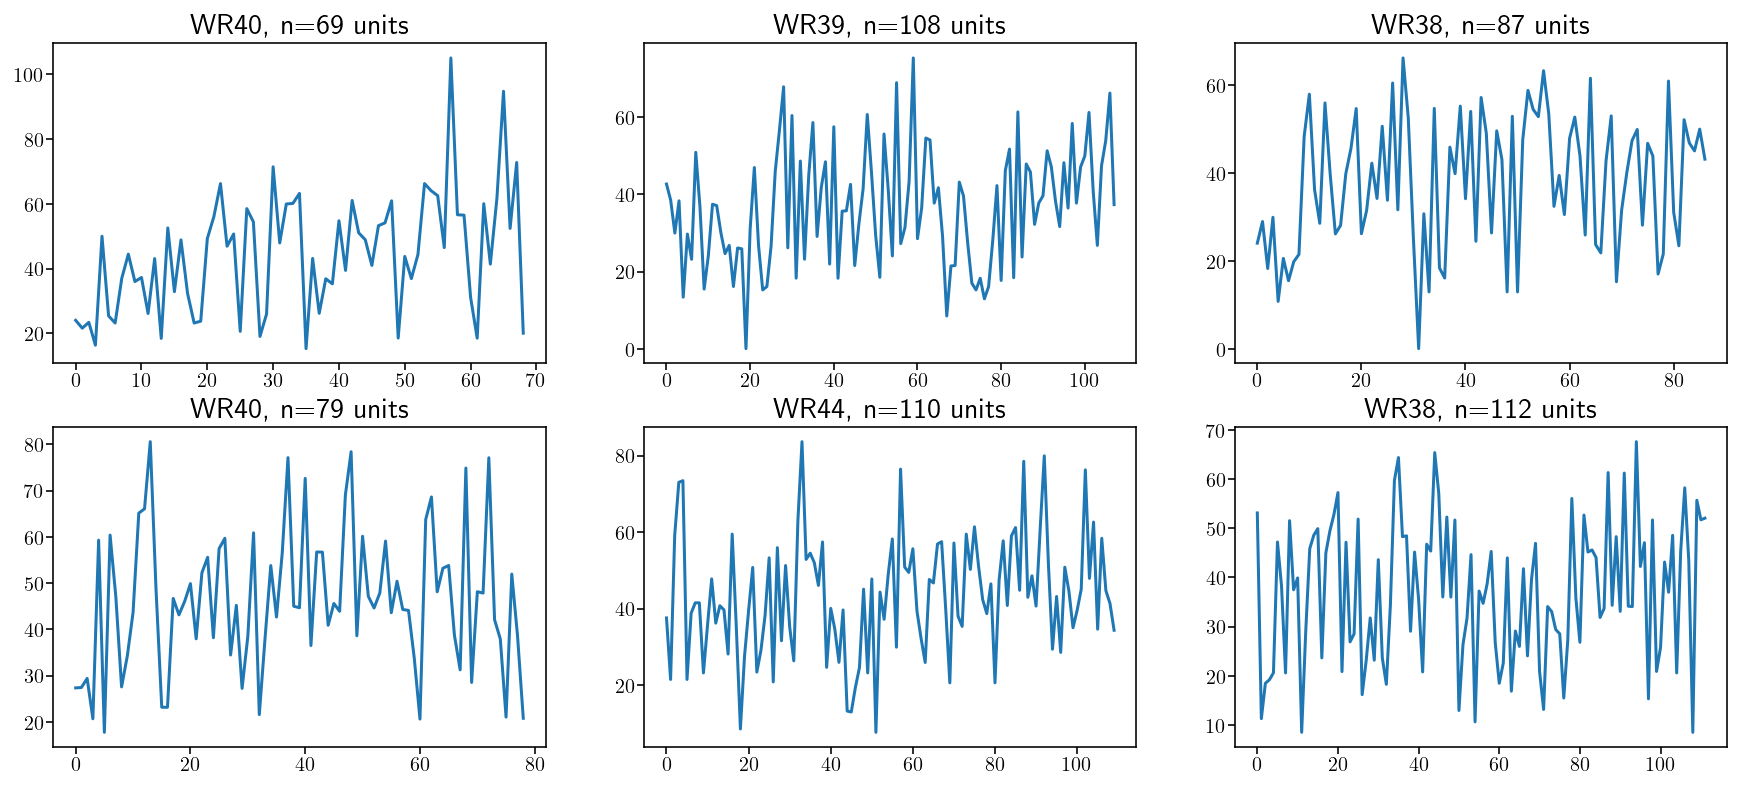

In [11]:
warnings.filterwarnings("ignore")
plt.figure(figsize=(15,10))

signal = 'M1_rates'
signal = 'Str_rates'
for i,df in enumerate(AllDFs):
    ax = plt.subplot(3,3,i+1)    
    if signal not in df.columns: continue
    df_ = pyal.restrict_to_interval(df,epoch_fun=defs.exec_epoch)
    a = [np.max(fr,axis=0) for fr in df_[signal]]
    a = np.max(np.array(a),axis=0)
    ax.plot(a)
    ax.set_title(f'{df_.mouse[0]}, n={df_[signal][0].shape[1]} units')

warnings.filterwarnings("default")

PCA explained variance

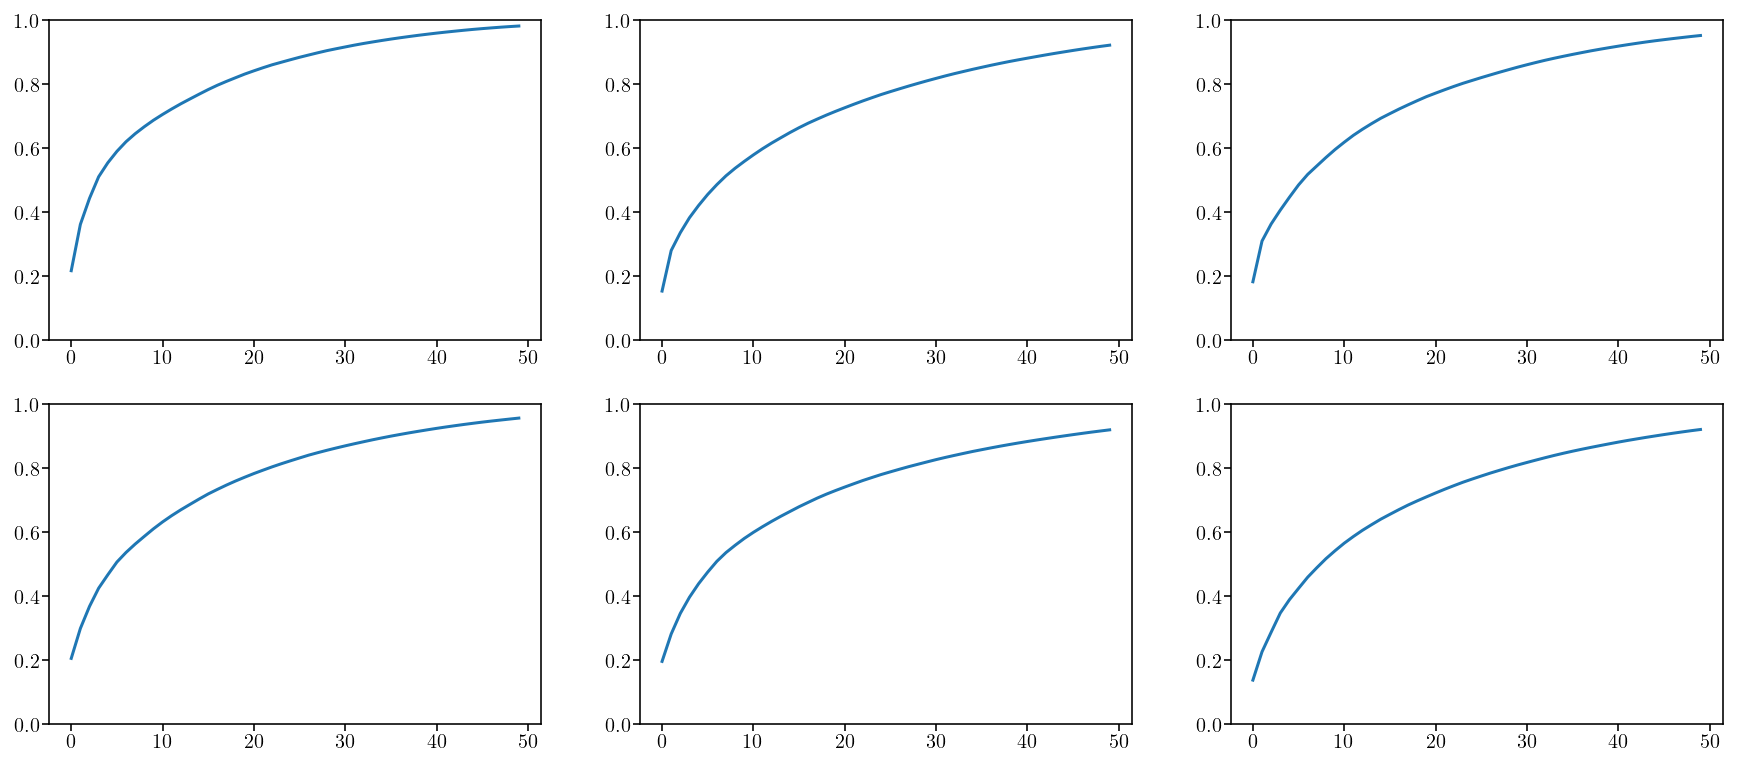

In [13]:
plt.figure(figsize=(15,10))
warnings.filterwarnings("ignore")

for i,df in enumerate(AllDFs):
    ax = plt.subplot(3,3,i+1)
    df_ = pyal.restrict_to_interval(df, epoch_fun=defs.exec_epoch)
    rates = np.concatenate(df_['Str_rates'].values, axis=0)
    rates -= np.mean(rates, axis=0)
    rates_model = PCA(n_components=50, svd_solver='full').fit(rates)
    ax.plot(np.cumsum(rates_model.explained_variance_ratio_))
    ax.set_ylim([0,1])
warnings.filterwarnings("default")

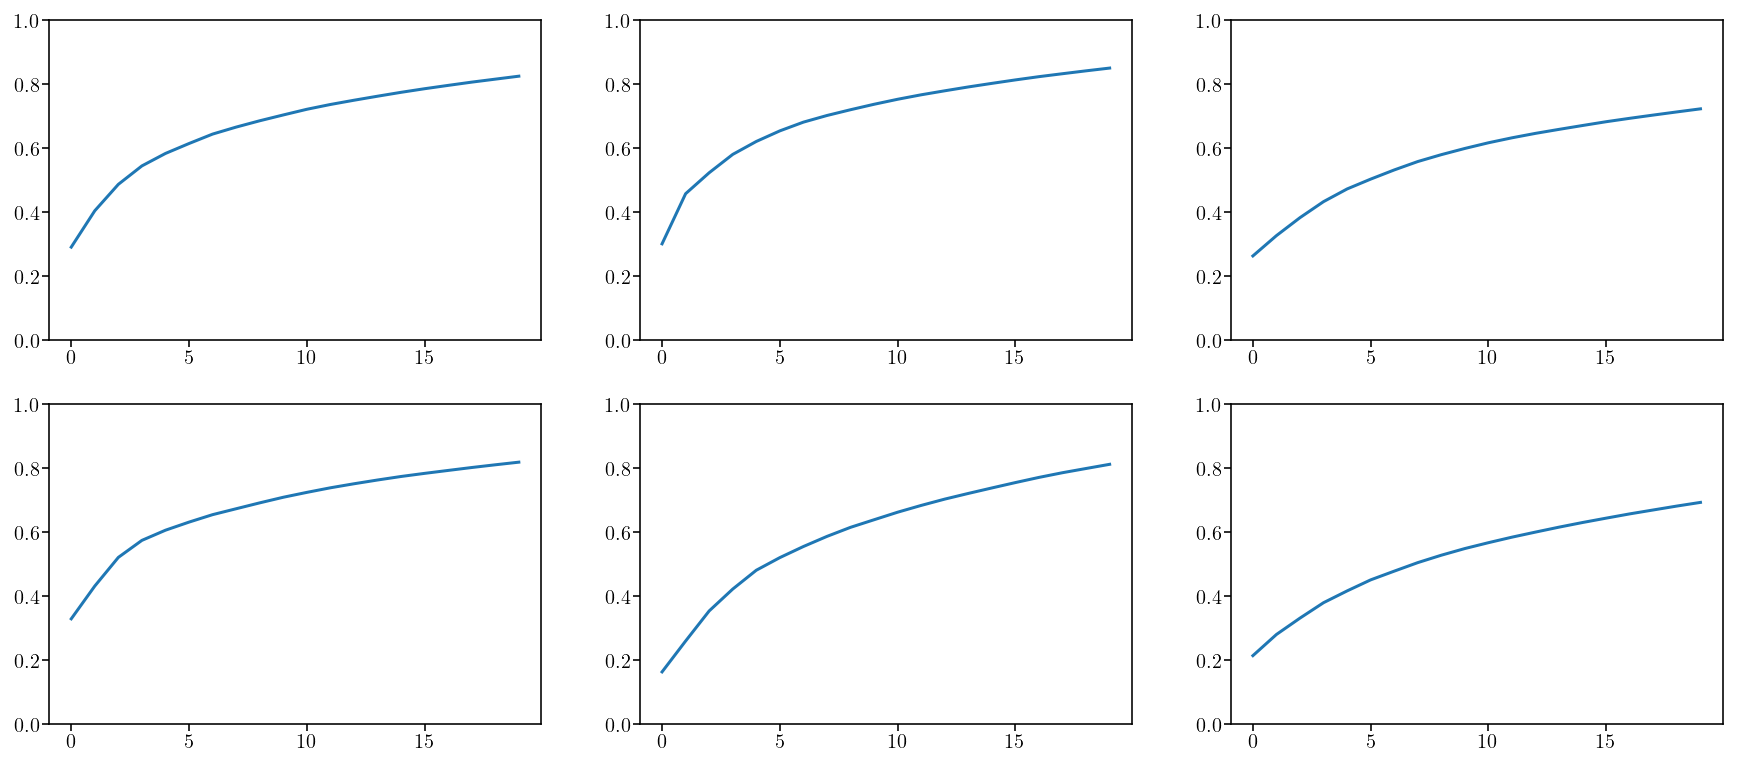

In [14]:
warnings.filterwarnings("ignore")

plt.figure(figsize=(15,10))
for i,df in enumerate(AllDFs):
    ax = plt.subplot(3,3,i+1)
    df_ = pyal.restrict_to_interval(df, epoch_fun=defs.exec_epoch)
    try:
        rates = np.concatenate(df_['M1_rates'].values, axis=0)
    except KeyError:
        continue
    rates -= np.mean(rates, axis=0)
    rates_model = PCA(n_components=20, svd_solver='full').fit(rates)
    ax.plot(np.cumsum(rates_model.explained_variance_ratio_))
    ax.set_ylim([0,1])
    
warnings.filterwarnings("default")

Check the number of trials per target

In [15]:
for df in AllDFs:
    print({df.file[0]})
    for target in np.unique(df.target_id):
        df_ = pyal.select_trials(df, df.target_id == target)
        print(f'target[{target}]: {len(df_.Str_rates)}')
    print()

{'js2p0_tbytSpkHandJsTrj10msBin_WR40_081919_ss.mat'}
target[0]: 13
target[1]: 25
target[2]: 29
target[3]: 27

{'js2p0_tbytSpkHandJsTrj10msBin_WR39_100219_ss.mat'}
target[0]: 15
target[1]: 26
target[2]: 21
target[3]: 25

{'js2p0_tbytSpkHandJsTrj10msBin_WR38_052219_ss.mat'}
target[0]: 20
target[1]: 39
target[2]: 34
target[3]: 28

{'js2p0_tbytSpkHandJsTrj10msBin_WR40_082019_ss.mat'}
target[0]: 14
target[1]: 28
target[2]: 14
target[3]: 13

{'js2p0_tbytSpkHandJsTrj10msBin_WR44_031020_ss.mat'}
target[0]: 19
target[1]: 28
target[2]: 24
target[3]: 36

{'js2p0_tbytSpkHandJsTrj10msBin_WR38_052419_ss.mat'}
target[0]: 16
target[1]: 19
target[2]: 22
target[3]: 19



check the weird session
`js2p0_tbytSpkHandJsTrj10msBin_WR39_100819_np2p0_strOnly_ss`

In [53]:
animalpath = animalFiles[5]

animalpath

'/data/mouse-data/js2p0_tbytSpkHandJsTrj10msBin_WR39_100819_np2p0_strOnly_ss.mat'

In [54]:
df = dt.load_pyal_data(animalpath)
df['mouse'] = fname.split(os.sep)[-1][fname.split(os.sep)[-1].find('WR'):].split('_')[0]
df['file'] = fname.split(os.sep)[-1]
# df = prep_general_mouse(df)

# data = dt.get_data_array(df, exec_epoch, area=areas[1], model=10)

In [55]:
a = df.unitTimeBStr[10]

a.toarray().shape

(154, 150)

So this session is in fact binned at 20ms.  
**Remove it totally**

---

# plot hand velocities

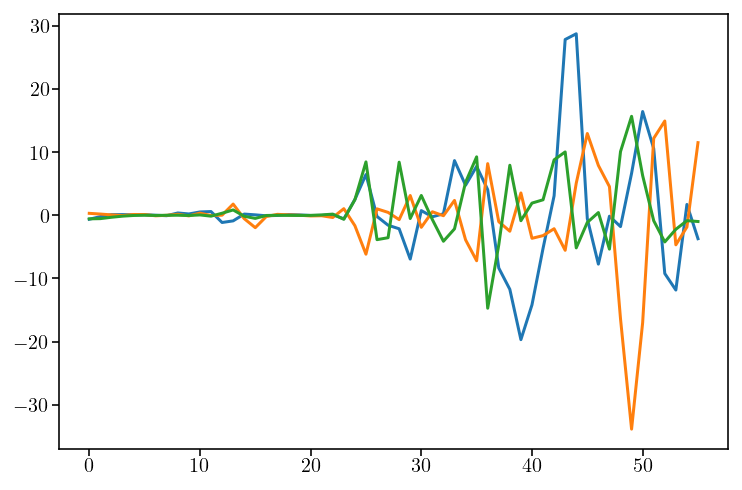

In [33]:
df = AllDFs[1]
plt.plot(df.hVelB[5])